<br>

### Installing Octopy-Energy

The first step to getting running with the library is to install it through pip.

In [1]:
! pip install octopyenergy

<br>

Once installed `octopyenergy` can be imported into your scripts.

In [25]:
import octopyenergy as oe
from octopyenergy.api import DownloadManager

<br>

### User Inputs

We now need to assign values for our account/meter details, add your own `.env` or replace with standard string assignments.

N.b. we recommend that you store your account details in a `.env` file and then use the `dotenv` library to set them as environment variables, which can in turn be picked up by `os` and assigned to local variables.

In [3]:
import os
import dotenv

dotenv.load_dotenv('../.env')

octopus_account = os.environ['OCTOPUS_ACCOUNT']
octopus_api_key = os.environ['OCTOPUS_API_KEY']
meter_mpan = os.environ['METER_MPAN']
meter_serial = os.environ['METER_SERIAL']

<br>

### Configuring the Download Manager

We'll start by initialising the `DownloadManager`, when we do so we can pass a number of parameters which will configure defaults in the download manager. The `octopus_api_key` is also required for some requests.

In [4]:
download_manager = DownloadManager(meter_mpan=meter_mpan, 
                                   meter_serial=meter_serial, 
                                   api_key=octopus_api_key)

download_manager

Welcome to the octopyenergy DownloadManager! For more information please read the documentation at https://github.com/AyrtonB/Octopy-Energy.

The following API end-points are available: 
retrieve_products, retrieve_product, retrieve_tariff_charges, retrieve_meter_point, retrieve_electricity_consumption, retrieve_gas_consumption, retrieve_gsps


<br>

One of the benefits of specifying these parameters is that they will be used to pre-populate the function docstrings.

In [5]:
help(download_manager.retrieve_meter_point)

Help on function retrieve_meter_point:

retrieve_meter_point(meter_mpan='1012627213444', **kwargs)
    Retrieves a meter-point
    
    Parameters:
        meter_mpan



<br>

Specifying those parameters also reduces the amount of arguments we need to pass when making data requests.

<AxesSubplot:xlabel='interval_start'>

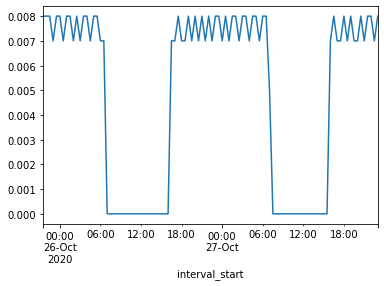

In [6]:
download_manager.create_elec_consumption_s().plot()

<br>

A number of the end-points do not require an API key or additional arguments, these will work even when no parameters are specified during the `DownloadManager` initialisation.

In [7]:
download_manager = DownloadManager()

download_manager.retrieve_gsps().json()

{'count': 14,
 'next': None,
 'previous': None,
 'results': [{'group_id': '_A'},
  {'group_id': '_B'},
  {'group_id': '_C'},
  {'group_id': '_D'},
  {'group_id': '_E'},
  {'group_id': '_F'},
  {'group_id': '_G'},
  {'group_id': '_H'},
  {'group_id': '_J'},
  {'group_id': '_K'},
  {'group_id': '_L'},
  {'group_id': '_M'},
  {'group_id': '_N'},
  {'group_id': '_P'}]}

<br>

For those that do an Exception will be raised detailing why the request was unsuccessful.

In [20]:
def request_electricity_consumption(download_manager, meter_mpan, meter_serial):
    try:
        download_manager.retrieve_electricity_consumption(meter_mpan=meter_mpan, meter_serial=meter_serial)
        print('Successfully retrieved!')

    except oe.api.SadOctopy as err:
        print(err)
        
request_electricity_consumption(download_manager, meter_mpan, meter_serial)

Authentication credentials were not provided.


<br>

This can easily be remedied by calling the `autheticate` method and passing your api key.

In [21]:
download_manager.authenticate(octopus_api_key)

request_electricity_consumption(download_manager, meter_mpan, meter_serial)

Successfully retrieved!


<br>

### Abstraction Levels

So far we've mainly used the `create_elec_consumption_s` method, this is a high-level function in the API that carries out the request and then converts the response into a tidied `pandas` series. Underneath this layer lie several lower-level functions which can provide us additional control.

Here we'll query the `retrieve_electricity_consumption` end-point and extract the JSON response.

In [22]:
from IPython.display import JSON

r = download_manager.retrieve_electricity_consumption(meter_mpan=meter_mpan, meter_serial=meter_serial)

JSON(r.json())

<IPython.core.display.JSON object>

<br>

We can use another `octopyenergy` helper function, `response_to_data` to convert the response into a dataframe.

N.b. this will only work for responses which can be converted into a dataframe, such as those from `retrieve_electricity_consumption` and `retrieve_gas_consumption`. 

In [38]:
s_elec_consumption = oe.api.response_to_data(r)

s_elec_consumption.head()

interval_start
2020-10-26 00:00:00+00:00    0.442
2020-10-19 00:30:00+01:00    3.520
2020-10-12 00:00:00+01:00    2.310
2020-10-10 00:30:00+01:00    0.392
Name: consumption, dtype: float64

<br>

The deepest abstraction level is available through the `query_endpoint` method, this provides access to all of the end-points but requires a larger number of parameters to be passed. The benefit of this level is that it can be easier to work with when the end-point being used is specified through another variable.

In [40]:
end_point = 'retrieve_electricity_consumption'

end_point_kwargs = {
    'meter_mpan': meter_mpan,
    'meter_serial': meter_serial,
    'group_by': 'week'
}

r = download_manager.query_endpoint(end_point, end_point_kwargs)

JSON(r.json())

<IPython.core.display.JSON object>